# Workflow that waits for Human Input

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")

In [2]:
# custom tools
# the docstring is important as it will be read by the LLM to identify a function
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first integer
        b: second integer
    """
    return a * b 

def add(a: int, b: int) -> int:
    """Add a and b.
    Args:
        a: first integer
        b: second integer
    """
    return a + b 

def divide(a: int, b: int) -> float:
    """Divide a by b.
    Args:
        a: first integer
        b: second integer
    """
    return a / b 

In [3]:
# Integrate tools with llm
tools = [multiply, add, divide]
llm_with_tools = llm.bind_tools(tools)

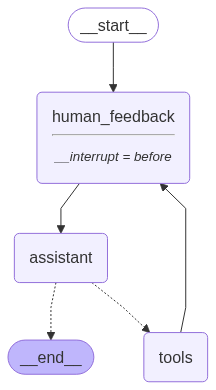

In [4]:
# workflow with langgraph
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# system message
sys_msg = SystemMessage(content = "You are a helpful assistant tasked with performing arithematic on a set of inputs.")

# nodes
def human_feedback(state: MessagesState):
    pass

def assistant(state: MessagesState):
    messages = [sys_msg] + state["messages"]
    ai_response = llm_with_tools.invoke(messages)
    return {"messages": state["messages"] + [ai_response]}

# graph
builder = StateGraph(MessagesState)

# define nodes
builder.add_node("human_feedback", human_feedback)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# define edges
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges("assistant", tools_condition, )
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()

# Human in the loop
graph = builder.compile(checkpointer = memory, interrupt_before=["human_feedback"])

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
config = {"configurable":{"thread_id":"1"}}
initial_input = {"messages": "Multiply 4 and 3"}

# run the graph till first interrupt
for event in graph.stream(initial_input, config, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

# get user_input
user_input = input("tell me how you want to update the state:")
graph.update_state(config, {"messages": user_input}, as_node = "human_feedback")

# continue the graph execution
for event in graph.stream(None, config, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 4 and 3
================================ Human Message =================================

please multiply 5 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (k0r46aahv)
 Call ID: k0r46aahv
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: multiply

30


In [7]:
for event in graph.stream(None, config, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

30
================================== Ai Message ==================================

The result of multiplying 5 and 6 is **30**.
